## 欺诈行为检测
本案例主要是分析金融交易中如何预测交易双方的欺诈行为, 根据相应的金融交易历史数据, 推断出某笔未知的交易是否为欺诈行为, 
能够辅助企业做出应对客户欺诈行为的措施, 能够在海量交易中帮助企业快速做出决断, 合理判断客户资质以及甄别违法行为等.
在本案例中, 主要采用逻辑回归的分类方法预测交易行为的性质.

本案例及其数据集来源链接:https://www.kaggle.com/ntnu-testimon/paysim1/data

案例使用的数据描述如下

step 小时

type 转账类型, 包含CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER

amount 转账金额

nameOrig 转账付款人

oldbalanceOrg 付款人交易前账户余额

newbalanceOrig 付款人交易后账户余额

nameDest 转账收款人

oldbalanceDest 收款人交易前账户余额

newbalanceDest 收款人交易后账户余额

isFraud 是欺诈行为(1), 不是欺诈行为(0)

isFlaggedFraud 交易金额是否超过20万货币单位, 是为1, 否为0

### 以下为分析过程
1. 导入数据集
2. 清洗/初步处理数据
3. 查看/筛选高价值数据
4. 建立和调整数学模型
5. 评估模型, 预测结果

In [1]:
#导入相关工具库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from scipy.stats import skew, boxcox
import zipfile
import os

In [2]:
#读取数据集准备
dataset_path = './'
csvfile_path=os.path.join(dataset_path, 'PS_20174392719_1491204439457_log.csv')

#读取数据集
raw_data = pd.read_csv(csvfile_path)
#查看数据集
#数据预览
print(raw_data.head())
print('\n')
#数据统计信息
print(raw_data.describe())
print('\n')
#数据集基本信息
print(raw_data.info())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06  

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


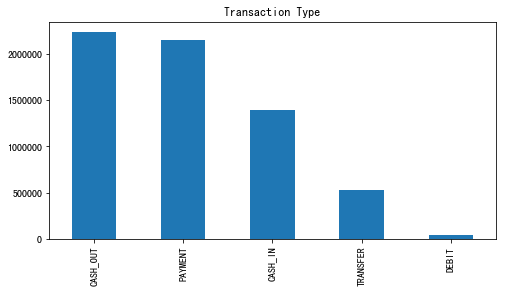

In [3]:
#查看转账类型
print(raw_data['type'].value_counts())

fig, ax=plt.subplots(1,1,figsize=(8,4))
raw_data['type'].value_counts().plot(kind='bar', title='Transaction Type', ax=ax, figsize=(8,4))
plt.show()

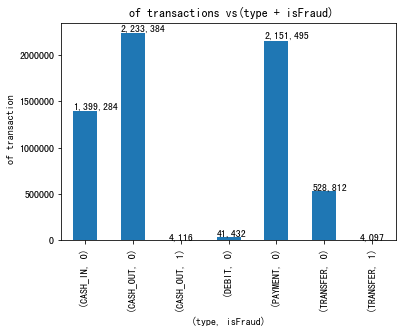

In [4]:
#查看转账类型和欺诈标记的记录
ax = raw_data.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title(' of transactions vs(type + isFraud)')
ax.set_xlabel('(type, isFraud)')
ax.set_ylabel(' of transaction')

#添加标注
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()),',d')),(p.get_x(),p.get_height()*1.01))

#### 由上图可以得知, 存在欺诈行为的转账类型为transfer和cash_out两种类型, 后面将单独分析这两种转账类型与欺诈行为之间的关系.

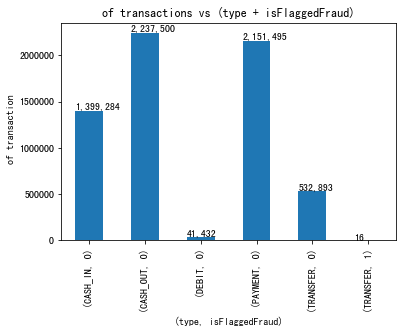

In [5]:
#查看转账类型和商业模型标记的欺诈记录
ax=raw_data.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar')
ax.set_title('of transactions vs (type + isFlaggedFraud)')
ax.set_xlabel('(type, isFlaggedFraud)')
ax.set_ylabel(' of transaction')

#添加标注
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()),',d')),(p.get_x(),p.get_height()*1.01))

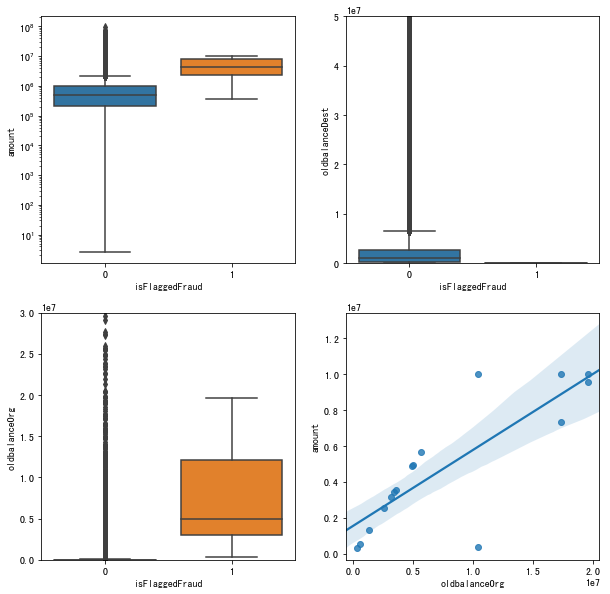

In [6]:
#重点分析transfer转账类型, 因为其中有欺诈行为, 但商业模型标记的数量占比较低
fig,axs=plt.subplots(2,2,figsize=(10,10))
transfer_data=raw_data[raw_data['type']=='TRANSFER']

a=sns.boxplot(x='isFlaggedFraud',y='amount',data=transfer_data,ax=axs[0][0])
axs[0][0].set_yscale('log')

b=sns.boxplot(x='isFlaggedFraud',y='oldbalanceDest',data=transfer_data,ax=axs[0][1])
axs[0][1].set(ylim=(0,0.5e8))

c=sns.boxplot(x='isFlaggedFraud',y='oldbalanceOrg',data=transfer_data,ax=axs[1][0])
axs[1][0].set(ylim=(0,3e7))

d=sns.regplot(x='oldbalanceOrg',y='amount',data=transfer_data[transfer_data['isFlaggedFraud']==1],ax=axs[1][1])
plt.show()

In [7]:
transfer_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,0,0
78,1,TRANSFER,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0,0


In [8]:
 #处理存在欺诈记录的转账类型的数据
used_data=raw_data[(raw_data['type']=='TRANSFER')|(raw_data['type']=='CASH_OUT')]
#删除暂时不同的数据列
used_data.drop(['step','nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)
#重新设置索引
used_data=used_data.reset_index(drop=True)

#将type转换成Boolean类型数据
type_label_encoder=preprocessing.LabelEncoder()
type_category=type_label_encoder.fit_transform(used_data['type'].values)
used_data['typeCategory']=type_category

print(used_data.head())

/Users/dongxiaow/.virtualenvs/mach/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


       type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0  TRANSFER     181.00          181.0             0.0             0.0   
1  CASH_OUT     181.00          181.0             0.0         21182.0   
2  CASH_OUT  229133.94        15325.0             0.0          5083.0   
3  TRANSFER  215310.30          705.0             0.0         22425.0   
4  TRANSFER  311685.89        10835.0             0.0          6267.0   

   newbalanceDest  isFraud  typeCategory  
0            0.00        1             1  
1            0.00        1             0  
2        51513.44        0             0  
3            0.00        0             1  
4      2719172.89        0             1  


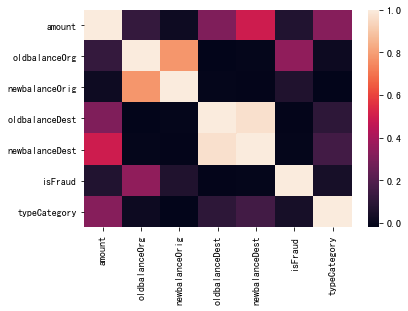

In [9]:
#查看变量间的相关性
sns.heatmap(used_data.corr())

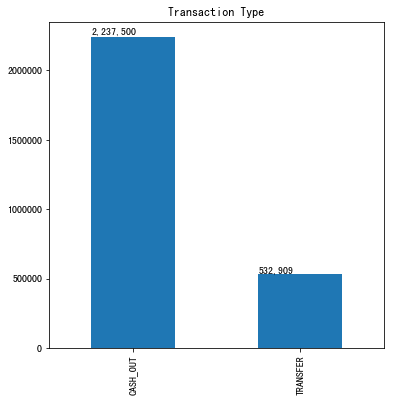

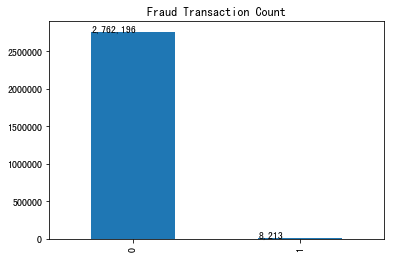

In [10]:
#查看转账类型记录个数
ax=used_data['type'].value_counts().plot(kind='bar',title='Transaction Type',figsize=(6,6))
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()),',d')),(p.get_x(),p.get_height()*1.01))
plt.show()

#查看转账类型中欺诈记录个数
ax=pd.value_counts(used_data['isFraud'],sort=True).sort_index().plot(kind='bar',title='Fraud Transaction Count')
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()),',d')),(p.get_x(),p.get_height()))
plt.show()

In [11]:
#建立模型进行预测
#准备数据
feature_names=['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','typeCategory']
x=used_data[feature_names]
y=used_data['isFraud']
print(x.head())
print(y.head())

      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  \
0     181.00          181.0             0.0             0.0            0.00   
1     181.00          181.0             0.0         21182.0            0.00   
2  229133.94        15325.0             0.0          5083.0        51513.44   
3  215310.30          705.0             0.0         22425.0            0.00   
4  311685.89        10835.0             0.0          6267.0      2719172.89   

   typeCategory  
0             1  
1             0  
2             0  
3             1  
4             1  
0    1
1    1
2    0
3    0
4    0
Name: isFraud, dtype: int64


In [12]:
#处理不平衡数据
#欺诈记录的条数
number_records_fraud=len(used_data[used_data['isFraud']==1])
#欺诈记录的索引
fraud_indices=used_data[used_data['isFraud']==1].index.values

#得到非欺诈记录的索引
nonfraud_indices=used_data[used_data['isFraud']==0].index

#随机选取相同数量的非欺诈记录
random_nonfraud_indices=np.random.choice(nonfraud_indices,number_records_fraud,replace=False)
random_nonfraud_indices=np.array(random_nonfraud_indices)

#整合两类样本的索引
under_sample_indices=np.concatenate([fraud_indices,random_nonfraud_indices])
under_sample_data=used_data.iloc[under_sample_indices,:]


x_undersample=under_sample_data[feature_names].values
y_undersample=under_sample_data['isFraud'].values

#显示样本比例
print('非欺诈记录比例:', len(under_sample_data[under_sample_data['isFraud']==0])/len(under_sample_data))
print('欺诈记录比例:',len(under_sample_data[under_sample_data['isFraud']==1])/len(under_sample_data))
print('欠采样记录数:',len(under_sample_data))

非欺诈记录比例: 0.5
欺诈记录比例: 0.5
欠采样记录数: 16426


#### 上述结果恰恰验证了前面数据采集的部分, 因为我们是选用了相同数量的欺诈行为记录和非欺诈行为记录, 因此这些行为的占比会是50%.

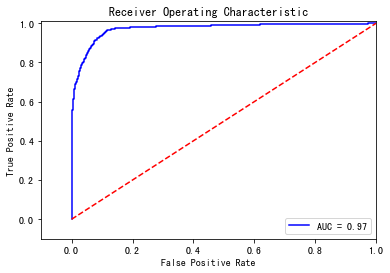

In [13]:
#采用逻辑回归模型进行预测
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,auc

#分割训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(x_undersample, y_undersample, test_size=0.3,random_state=0)

lr_model = LogisticRegression()
lr_model.fit(x_train, y_train)

y_pred_score = lr_model.decision_function(x_test)

fpr,tpr,thresholds = roc_curve(y_test,y_pred_score)
roc_auc=auc(fpr,tpr)

#制作ROC曲线, 检验该模型的拟合情况
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### 如图为ROC曲线, 该曲线向左上角凸出效果显著, 表面该模型拟合状况良好, 能够较为准确地预测客户的欺诈行为.
#### 以下内容为该预测模型的基本状况

In [14]:
print(lr_model)
print(lr_model.intercept_ )
print(lr_model.coef_)
print(x.columns.tolist())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
[-1.21273105e-09]
[[-1.16695120e-06  2.39179121e-05 -2.33567264e-05  1.37031313e-05
  -1.39690973e-05  4.77284963e-10]]
['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'typeCategory']
